In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle

# Labelilng

In [3]:
# PATHS
# path to the folder containing the subfolders with the training images
trainpath = '/kaggle/input/intel-image-classification/seg_train/seg_train'
# path to the folder containing the subfolders with the testing images
testpath = '/kaggle/input/intel-image-classification/seg_test/seg_test'
predpath = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [4]:
# Create a dictionary to change text labels into int numerical labels
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}

print(class_labels)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
# def for labeling 

import os
from PIL import Image
IMAGE_SIZE = (150, 150)

def labeling(folder_path, images, labels):
    # loop through all subfolders in the folder_path
    for label in os.listdir(folder_path):
        # get the path to the subfolder
        label_path = os.path.join(folder_path, label)

        # convert label text to label number
        label_number = class_labels[label]

        # loop through all images in subfolder
        for file_name in os.listdir(label_path):
            # upload image using Pillow
            image = Image.open(os.path.join(label_path, file_name))

            # resize image to desired size
            image = image.resize(IMAGE_SIZE)

            # convert the image to a Numpy array  
            image = np.array(image)

            # add image to testing_image list
            images.append(image)

            # add image label to testing_label list
            labels.append(label_number)
    # convert the images and labels list to numpy array
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    return images, labels



In [6]:
# Training labeling
# list to store the images and their labels
training_images = []
training_labels = []
x_train, y_train = labeling(trainpath, training_images, training_labels)

# Testing labeling
# list to store the images and their labels
testing_images = []
testing_labels = []
x_test, y_test = labeling(testpath, testing_images, testing_labels)


# Data visualization

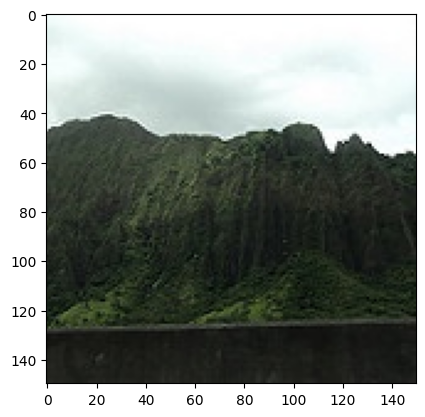

In [7]:
plt.imshow(training_images[5])

In [8]:
print(training_labels[5])

3


In [9]:
del training_images
del training_labels
del testing_images
del testing_labels



# Data prepatation

In [10]:
# Find the unique numbers from the train labels
num_clases = len(np.unique(y_train))

# Change the labels from categorical to one-hot encoding
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)


In [11]:
# Visualize y_train after one hot encoding
y_train[0]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

### Normalization

In [12]:
# Using Z-score normalization to converge faster and improve accuracy
mean = np.mean(x_train)
std = np.std(x_train)


x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)


### validation data

In [13]:
# Split train and valid
x_train, x_valid , y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=13)

In [14]:
print('train;', x_train.shape[0])
print('val;', x_valid.shape[0])
print('test;', x_test.shape[0])

train; 12630
val; 1404
test; 3000


# Building the convnet model

In [15]:
base_filtros = 32
w_regulatizer = 1e-4

In [16]:
x_train.shape[1:]

(150, 150, 3)

In [17]:
model = Sequential()
## conv 1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(30,activation='relu'))
model.add(Dense(num_clases,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 150, 150, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                        

## Data augmentation

In [18]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

## Compiling

In [19]:
from tensorflow.keras import optimizers

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
             metrics=['accuracy'])

## Callbacks

In [21]:
chekcpoint = ModelCheckpoint('mejor_modelo_denses1s.hdf5',verbose=1,save_best_only=True, monitor = 'val_accuracy')

## Training

In [ ]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=128),
          callbacks=[chekcpoint],
          steps_per_epoch=x_train.shape[0] // 128, 
          epochs=50,
          verbose=1,
          validation_data=(x_valid, y_valid),
                 shuffle=True)

Epoch 1/50


2023-05-16 23:09:51.381232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - ETA: 0s - loss: 2.1661 - accuracy: 0.3124
Epoch 1: val_accuracy improved from -inf to 0.19231, saving model to mejor_modelo_denses1s.hdf5
98/98 [==============================] - 102s 850ms/step - loss: 2.1661 - accuracy: 0.3124 - val_loss: 1.8709 - val_accuracy: 0.1923
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 1.6070 - accuracy: 0.3508
Epoch 2: val_accuracy improved from 0.19231 to 0.21296, saving model to mejor_modelo_denses1s.hdf5
98/98 [==============================] - 79s 799ms/step - loss: 1.6070 - accuracy: 0.3508 - val_loss: 2.0980 - val_accuracy: 0.2130
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 1.5453 - accuracy: 0.4030
Epoch 3: val_accuracy improved from 0.21296 to 0.34259, saving model to mejor_modelo_denses1s.hdf5
98/98 [==============================] - 78s 794ms/step - loss: 1.5453 - accuracy: 0.4030 - val_loss: 1.5898 - val_accuracy: 0.3426
Epoch 4/50
98/98 [====================

# Displaying curves of loss and accuracy during training

In [ ]:
def graph_loss_in_epochs(hist, save_image_filename, title):
    training_loss = hist.history['loss']
    test_loss = hist.history['val_loss'] #[10 9 8 5 6 7] 3
    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1) #[1 2 3 4 5 6]
    # Visualize loss history
    plt.title(title)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Val Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.axvline(x = epoch_count[test_loss.index(min(test_loss))], color = 'c', linestyle="dotted")
    plt.savefig('denses1sloss.png')
    plt.show()

In [ ]:
graph_loss_in_epochs(hist, 'train_vs_val_loss.png', 'Train vs Validation Loss')

In [ ]:
# Defining accuracy and loss plot funtion
def plot_loss_accuracy(hist, len_epochs):
  epochs = len_epochs
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'r--', label='Training Accuracy')
  plt.plot(epochs_range, val_acc,'b-' , label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'r--', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'b-', label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
plt.savefig('denses1sacloss.png')
plt.show()

In [ ]:
# Call the function to plot the curves
plot_loss_accuracy(hist, 120)

In [ ]:
model2 = model

In [ ]:
model2.load_weights('./mejor_modelo_denses1s.hdf5') 

In [ ]:
model2.save('shapes_cnnD.h5')

# Results

In [ ]:
model2.evaluate(x_test,y_test)

In [ ]:
# Inspired by: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

# Predicting the class of unseen images
from PIL import Image

img_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred/10038.jpg'
img = Image.open(img_path)
img = img.resize((150,150))
img_tensor = np.asarray(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor.astype('float32')
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)



In [ ]:
# predicting images
predicted_probs = model2.predict(img_tensor)
predicted_class_idx = np.argmax(predicted_probs)
predicted_class_label = class_names[predicted_class_idx]
print("Predicted class is:", predicted_class_label)



# Save training metrics

In [ ]:
import csv
# Extrae las métricas de rendimiento para cada época desde el objeto de historial:
train_loss = hist.history['loss']
train_acc = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']

# Abre el archivo CSV y escribe las métricas de rendimiento:
with open('metrics120.csv', 'a') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(len(train_loss)):
        writer.writerow([train_loss[i], train_acc[i], val_loss[i], val_acc[i]])


In [ ]:
import pickle
from pickle import dump
from pickle import load

def save_model(model, file_name):
    dump(model, open(file_name, 'wb'))
    
def load_model(file_name):
    return load(file_name, 'rb')
    

In [ ]:
file_name = 'pickle_model_epoch120.pkl'
save_model(model, file_name)

In [ ]:
del x_train
del y_train
del x_valid
del y_valid

# Visualizing intermediate activations

In [ ]:
# Instantiating a model from an input tensor and a list of output tensors
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
# Running the model in predict mode
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [ ]:
# Visualizing every channel in every intermediate activation
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
​
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')